In [1]:
from transforms import *
from torchvision.transforms import *
import librosa
import utils.config as config
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from functools import partial
from datasets.librispeech import convert_to_mel
import soundfile
import resampy

def tensor_to_img(spectrogram):
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(spectrogram, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.tight_layout()

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


In [2]:
audio_path = '/Users/vigi99/AirtelDEV/VoiceDataForAirtel/CommonCorpusTest/sample-114726.wav'
audio, original_sampling_rate = soundfile.read(audio_path, dtype='float32')
audio = resampy.resample(audio, 16000, original_sampling_rate, axis=-1)
# audio, _ = librosa.core.load(audio_path, sr=16000)
data = {'samples': audio, 'sample_rate': config.sampling_rate, 'epoch': 0}
to_stft = ToSTFT(n_fft=config.n_fft, hop_length=config.hop_length, win_length=config.window_length)
spec_2_mel = ToMelSpectrogramFromSTFT(n_mels=config.num_mel_banks)
train_transforms = Compose([to_stft, spec_2_mel, DeleteSTFT(), ToAudioTensor(['mel_spectrogram'])])
train_norm_transforms = Compose([to_stft, spec_2_mel, DeleteSTFT(), PerChannelNormalization(), ToAudioTensor(['mel_spectrogram'])])
train_spec_norm_transforms = Compose([to_stft, spec_2_mel, DeleteSTFT(), PerChannelNormalization(), SpecAugmentOnMel(), ToAudioTensor(['mel_spectrogram'])])

In [3]:
def cutout(image, percen, num_cuts, p, mask_color=0):
    mask_size = int(percen * min(image.shape))
    mask_size_half = mask_size // 2
    offset = 1 if mask_size % 2 == 0 else 0
    image = np.asarray(image).copy()
    if np.random.random() > p:
        return image
    h, w = image.shape[:2]
    for i in range(num_cuts):
        cxmin, cxmax = mask_size_half, w + offset - mask_size_half
        cymin, cymax = mask_size_half, h + offset - mask_size_half
        cx = np.random.randint(cxmin, cxmax)
        cy = np.random.randint(cymin, cymax)
        xmin = cx - mask_size_half
        ymin = cy - mask_size_half
        xmax = xmin + mask_size
        ymax = ymin + mask_size
        xmin = max(0, xmin)
        ymin = max(0, ymin)
        xmax = min(w, xmax)
        ymax = min(h, ymax)
        image[ymin:ymax, xmin:xmax] = mask_color
    return image

def transform_cut(spec, percentage):
    return cutout(spec, percentage, 20, 1)

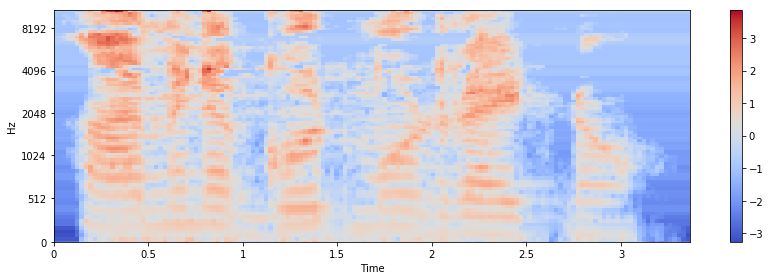

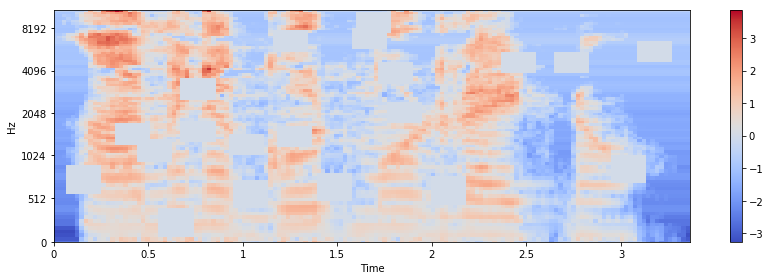

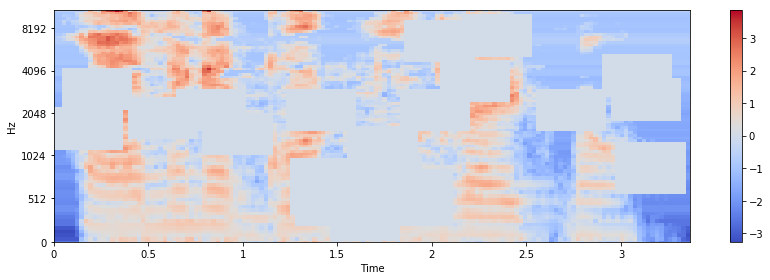

In [4]:
audio_spec_norm = train_norm_transforms(data)
audio_specaug_norm = train_spec_norm_transforms(data)
audio_speccut_norm_1 = transform_cut(audio_spec_norm, 0.1)
audio_speccut_norm_2 = transform_cut(audio_spec_norm, 0.2)
tensor_to_img(audio_specaug_norm)
tensor_to_img(audio_speccut_norm_1)
tensor_to_img(audio_speccut_norm_2)

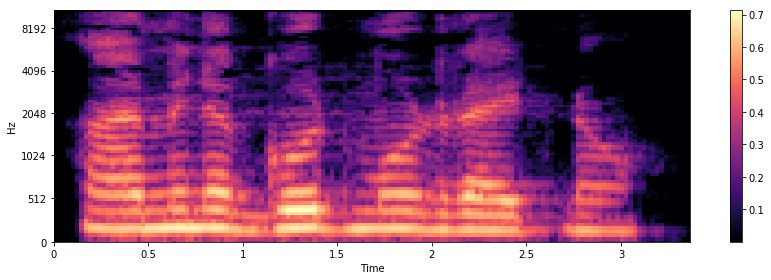

In [5]:
def get_spectrograms(audio, ref_db=20, max_db=100):
    y = audio
    linear = librosa.stft(y=y,
                          n_fft=config.n_fft,
                          hop_length=config.hop_length,
                          win_length=config.window_length)
    mel_basis = librosa.filters.mel(config.sampling_rate, config.n_fft, config.num_mel_banks)
    mag = np.abs(linear)
    mel = np.dot(mel_basis, mag)
    mel = 20 * np.log10(np.maximum(1e-5, mel))
    mel = np.clip((mel - ref_db + max_db) / max_db, 1e-8, 1)
    mel = mel.astype(np.float32)
    return mel

def get_spectrograms2(audio, ref_db=20, max_db=100):
    y = audio
    linear = librosa.stft(y=y,
                          n_fft=config.n_fft,
                          hop_length=config.hop_length,
                          win_length=config.window_length)
    mel_basis = librosa.filters.mel(config.sampling_rate, config.n_fft, config.num_mel_banks)
    mag = np.abs(linear)**2
    mel = np.dot(mel_basis, mag)
    mel = librosa.power_to_db(mel, ref=1, top_db=100)
    mel = np.clip((mel - ref_db + max_db) / max_db, 1e-8, 1)
    mel = mel.astype(np.float32)
    return mel

def get_mel(audio):
    return convert_to_mel(audio.reshape(1, -1))

spec_dctts = get_mel(audio)

# spec_dctts2 = get_spectrograms2(audio)
tensor_to_img(spec_dctts)
# tensor_to_img(spec_dctts2)

In [6]:
y = audio
linear = librosa.stft(y=y,
                      n_fft=config.n_fft,
                      hop_length=config.hop_length,
                      win_length=config.window_length)
mel_basis = librosa.filters.mel(config.sampling_rate, config.n_fft, config.num_mel_banks)
mag = np.abs(linear)
mel = np.dot(mel_basis, mag)
mel = 20 * np.log10(np.maximum(1e-5, mel))
np.max(mel)

-8.580493

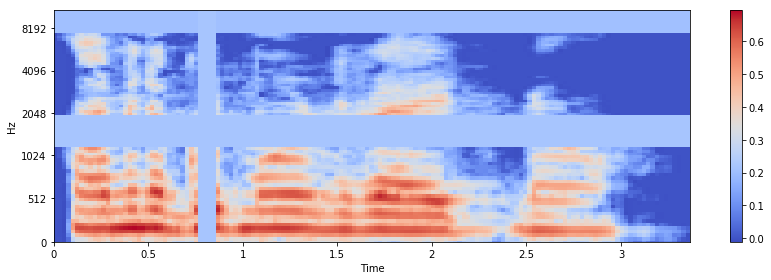

In [7]:
def convert_to_mel2(signal):
    data = {'samples': signal.squeeze(0), 'sample_rate': config.sampling_rate}
    to_stft = ToSTFT(n_fft=config.n_fft, hop_length=config.hop_length, win_length=config.window_length)
    convert_to_mel = ToMelSpectrogramFromSTFT(n_mels=config.num_mel_banks)
    transforms = Compose([to_stft, convert_to_mel, DeleteSTFT(), ToAudioTensor(['mel_spectrogram'])])
    return transforms(data)

def image_train_transform(signal, epoch=100):
    data = {'mel_spectrogram': convert_to_mel2(signal), 'sample_rate': config.sampling_rate, 'epoch': epoch}
    transforms = Compose([SpecAugmentOnMel(), ToAudioTensor(['mel_spectrogram'])])
    return transforms(data)

signal = audio.reshape(1, -1)
spec_dctts = image_train_transform(signal)
tensor_to_img(spec_dctts)

In [8]:
spec_dctts.max()

0.6959908